# Solución del desafío LATAM - Felipe Moya González

<br>

---

<br>

## Librerías necesarias

In [522]:
# Importamos las librerías a utilizar
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
from janitor import clean_names
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Dejaremos una semilla para que los resultados obtenidos sean reproducibles.

In [523]:
np.random.seed(201212189)

<br>

---

<br>

## Carga de datos

Lo primero que debemos hacer es cargar los datos. Cargamos `Vlo-I` y `Vlo-O` como texto, pues hay algunos valores que contienen la letra P.

In [524]:
# Definimos variables para las rutas de los archivo
input_path = "data/input"
output_path = "data/output" 

# Cargamos los datos entregados
vuelos = pd.read_csv(os.path.join(input_path, "dataset_SCL.csv"), dtype={1: object, 6: object}).clean_names()

# Definimos la cantidad de filas y de columnas de la base
filas, columnas = vuelos.shape

<br>

---

<br>

## Limpieza de datos y análisis exploratorio

Veamos alguna información de los datos:

In [525]:
# Veamos algunas observaciones de los datos
vuelos.head()

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,ano,dianom,tipovuelo,opera,siglaori,siglades
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [526]:
# Mostramos las dimensiones de los datos.
print(f"\n La base contiene {filas} observaciones y {columnas} columnas.")


 La base contiene 68206 observaciones y 18 columnas.


In [527]:
# Veamos si todas las variables tienen el tipo adecuado
vuelos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha_i    68206 non-null  object
 1   vlo_i      68206 non-null  object
 2   ori_i      68206 non-null  object
 3   des_i      68206 non-null  object
 4   emp_i      68206 non-null  object
 5   fecha_o    68206 non-null  object
 6   vlo_o      68205 non-null  object
 7   ori_o      68206 non-null  object
 8   des_o      68206 non-null  object
 9   emp_o      68206 non-null  object
 10  dia        68206 non-null  int64 
 11  mes        68206 non-null  int64 
 12  ano        68206 non-null  int64 
 13  dianom     68206 non-null  object
 14  tipovuelo  68206 non-null  object
 15  opera      68206 non-null  object
 16  siglaori   68206 non-null  object
 17  siglades   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Notamos que no todas las columnas tienen el tipo adecuado, así que ahora las pasamos al tipo adecuado: 

In [528]:
# Convertimos las variables en su tipo
vuelos["fecha_i"] = pd.to_datetime(vuelos["fecha_i"], format="%Y-%m-%d")
vuelos["fecha_o"] = pd.to_datetime(vuelos["fecha_o"], format="%Y-%m-%d")

#### Valores faltantes:

Ahora revisaremos si es que hay valores faltantes en alguna de las columnas, para luego ver como encargarse de ellos.

In [529]:
# Valores faltantes por columna
vuelos.isna().sum()

fecha_i      0
vlo_i        0
ori_i        0
des_i        0
emp_i        0
fecha_o      0
vlo_o        1
ori_o        0
des_o        0
emp_o        0
dia          0
mes          0
ano          0
dianom       0
tipovuelo    0
opera        0
siglaori     0
siglades     0
dtype: int64

Notamos que la única variable con valores faltantes es `vlo-o`. Veamos esa fila para tratar de entender porqué no tiene valor.

In [530]:
# Revisión fila con valor faltante
vuelos[vuelos["vlo_o"].isna()]

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,ano,dianom,tipovuelo,opera,siglaori,siglades
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Es un vuelo de Santiago a Lima, que tiene un número de vuelo programado, pero no un número de vuelo real. Por lo tanto, podemos reemplazar el valor faltante por el valor de la columna `vlo-i`, es decir con el número de vuelo programado.

In [531]:
# Reemplazamos por el número de vuelo programado
vuelos.loc[vuelos["vlo_o"].isna(), "vlo_o"] = vuelos.loc[vuelos["vlo_o"].isna(), "vlo_i"]

<br>

---

<br>

# 1.) 

## Distribución de los datos:

Observando cada columna, podemos ver que la mayorías de las variables son de texto, por lo que no podemos asociarle alguna distribución estadística. Además las que son numéricas son códigos de vuelo o fechas, por lo que tampoco podemos asociarle alguna distribución estadística. Lo que sí podemos hacer es ver la distribución de los datos en términos de cantidades por: `mes`, `día de la semana`, `ciudad de destino`, `nombre de la aerolinea`, etc, para ver si hay valores que se repitan más que otros.

Definiremos una función que nos sirva para graficar la distribución de los datos en términos de cantidades por categoría.

In [532]:
# Función para graficar las distintas variables
def graph_bar(df: pd.DataFrame, col: str, quant: str, title: str, col_aux = None):
    """
    Función para graficar barras.
    """
    if col_aux:
        df_graph = df.sort_values(col_aux, ascending = False)
    else: 
        df_graph = df.sort_values(quant, ascending = True)

    # Dejamos solamente 15 valores para que el gráfico no sea tan grande
    df_graph = df_graph.iloc[-15:, :]

    # Creamos el gráfico
    fig, ax = plt.subplots(figsize=(8, 6))

    # Hacemos el eje y
    ax.set_yticks(range(len(df_graph)))
    ax.set_yticklabels(df_graph[col])

    # Definimos la etiqueta y el rango del eje x
    ax.set_xlabel("Cantidad de vuelos")
    ax.set_xlim(0, df_graph[quant].max() + 1000)

    # Definimos el título
    ax.set_title(f"Cantidad de vuelos por {title}", fontsize=16)

    # Graficamos las barras
    bars = ax.barh(range(len(df_graph)), df_graph[quant], color="#2A0087")

    # Agregamos la cantidad de vuelos en cada barra
    for i, bar in enumerate(bars):
        ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, df_graph[quant].iloc[i], va="center")

    # Mostramos el gráfico
    plt.show()

### Cantidad de vuelos por mes:

In [533]:
# Nombre del mes
vuelos["mes_nom"] = vuelos["mes"].map({1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto", 9: "Septiembre", 
    10: "Octubre", 11: "Noviembre", 12: "Diciembre"
    })

In [534]:
# Vuelos por mes
vuelos_mensuales = (
    vuelos.groupby(["mes_nom", "mes"]).agg(
        cantidad_vuelos = pd.NamedAgg(column="vlo_i", aggfunc="count")
    ).reset_index()
)

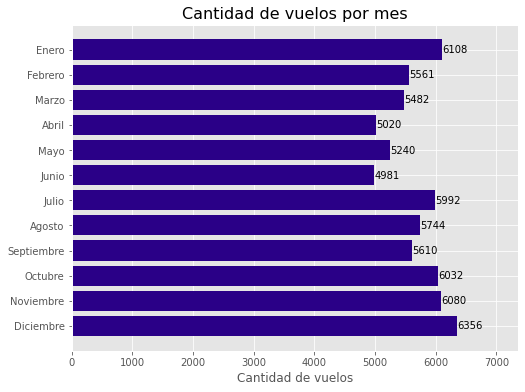

In [535]:
# Graficamos
graph_bar(vuelos_mensuales, "mes_nom", "cantidad_vuelos", "mes", "mes")

### Cantidad de vuelos por día de la semana:

In [536]:
# Día de la semana numérico
vuelos["dia_semana_num"] = vuelos["dianom"].map({"Lunes": 1, "Martes": 2, "Miercoles": 3, "Jueves": 4, "Viernes": 5, "Sabado": 6, "Domingo": 7})

In [537]:
# Vuelos por día de la semana
vuelos_sem = (
    vuelos.groupby(["dianom", "dia_semana_num"]).agg(
        cantidad_vuelos = pd.NamedAgg(column="vlo_i", aggfunc="count")
    ).reset_index()
)

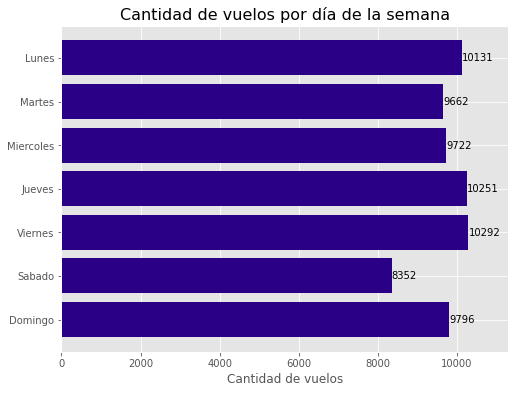

In [538]:
# Graficamos
graph_bar(vuelos_sem, "dianom", "cantidad_vuelos", "día de la semana", "dia_semana_num")

### Cantidad de vuelos por ciudad de destino:

In [539]:
# Vuelos por ciudad de destino
vuelos_dest = (
    vuelos.groupby("siglades").agg(
        cantidad_vuelos = pd.NamedAgg(column="vlo_i", aggfunc="count")
    ).reset_index()
)

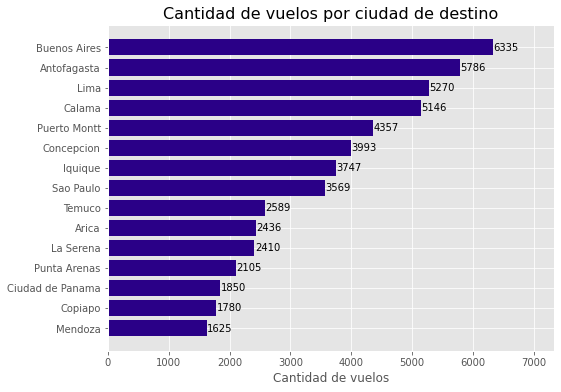

In [540]:
# Graficamos
graph_bar(vuelos_dest, "siglades", "cantidad_vuelos", "ciudad de destino")

### Cantidad de vuelos por aerolínea:

In [541]:
# Vuelos por aerolínea
vuelos_aero = (
    vuelos.groupby("opera").agg(
        cantidad_vuelos = pd.NamedAgg(column="vlo_i", aggfunc="count")
    ).reset_index()
)

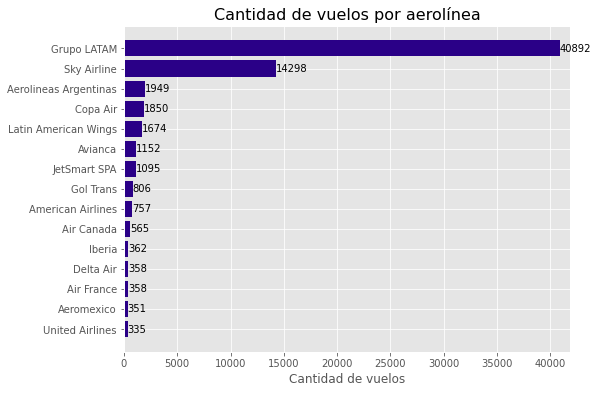

In [542]:
# Graficamos
graph_bar(vuelos_aero, "opera", "cantidad_vuelos", "aerolínea")

### Cantidad de vuelos por tipo de vuelo:

In [543]:
# Vuelos por aerolínea
vuelos_tipo = (
    vuelos.groupby("tipovuelo").agg(
        cantidad_vuelos = pd.NamedAgg(column="vlo_i", aggfunc="count")
    ).reset_index()
)

# Agregamos el nombre completo para que se vea mejor en el gráfico
vuelos_tipo["tipovuelo"] = vuelos_tipo["tipovuelo"].map({"N": "Nacional", "I": "Internacional"})

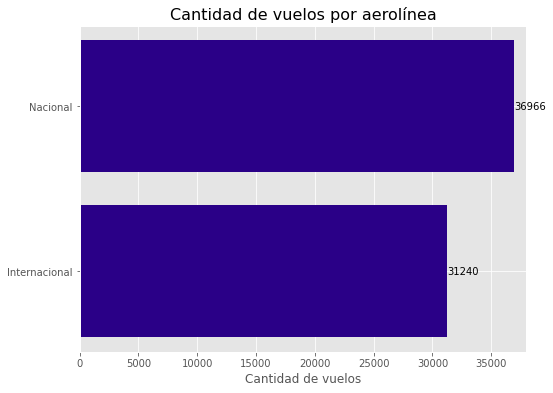

In [544]:
# Graficamos
graph_bar(vuelos_tipo, "tipovuelo", "cantidad_vuelos", "aerolínea")

## Ideas importantes

Viendo las 4 figuras podemos notar lo siguiente:

- Diciembre es el mes donde más vuelos tuvieron lugar en el aeropuerto de Santiago. Mientras que Junio fue el mes con menor cantidad de vuelos.
- El día de la semana con mayor cantidad de viajes es el viernes, mientras que el día con menor cantidad de viajes es el sábado. Parece extraño de todas maneras que el sábado haya tan poca cantidad de vuelos.
- También podemos notar que la ciudad de destino con mayor cantidad de vuelos es Buenos Aires, lo siguen Antofagasta Lima y Calama. 
- Por último, la aerolínea con mayor cantidad de vuelos es LATAM, seguida de Sky Airline y Aerolíneas Argentinas. Notamos también que la diferencia entre la cantidad de vuelos de LATAM y todas las demás aerolíneas es muy grande.

## Conclusiones

Por el momento no podemos sacar muchas conclusiones del análisis, pero lo que se puede concluir hasta el momento es lo siguiente:
- El flujo del aeropuerto entre Octubre y Enero es mayor que el flujo los demás meses del año. Además parece ser que los meses de vacaciones son los que tienen mayor cantidad de vuelos, lo cual es lógico, pero vemos que los datos se condicen con lo que se esperaría.
- Los jueves y viernes son los días más concurridos. Tiene sentido pues la gente suele viajar los fines de semana para ver a sus familiares o amigos que viven en otra ciudad/país. 
- La aerolínea LATAM demuestra ser la más popular en el aeropuerto de Santiago.
- Viendo que en todos los casos la ciudad de origen es Santiago, podemos concluir que los datos son todos de despegue en Santiago y aterrizaje en otra ciudad.

Por el momento no hay información que nos sirva para determinar el por qué del retraso de los vuelos, pero más adelante veremos si podemos sacar alguna conclusión sobre eso.

<br>

---

<br>

# 2.) 

## Creación de columnas adicionales

Ahora crearemos las columnas adicionales que se piden, para luego exportarlas a un archivo csv.

In [545]:
# high_season
vuelos["high_season"] = vuelos["fecha_i"].apply(lambda x: 
1 if (x.month == 12 and x.day >= 15) or \
    x.month == 1 or x.month == 2 or \
        (x.month == 3 and x.day <= 3) or \
            (x.month == 7 and x.day >= 15) or \
                (x.month == 9 and x.day >= 11) else 0)

# min_diff
vuelos["min_diff"] = vuelos.apply(lambda x: (x["fecha_o"] - x["fecha_i"]).seconds / 60 if (x["fecha_o"] > x["fecha_i"]) else 0, axis = 1).astype(int)

# delay_15
vuelos["delay_15"] = vuelos["min_diff"].apply(lambda x: 1 if x >= 15 else 0)

# period_day
vuelos["period_day"] = vuelos["fecha_i"].apply(lambda x: "Morning" if (x.hour < 12 and x.hour >= 5) else "Afternoon" if (x.hour < 19 and x.hour >= 12) else "Night")

Para el cálculo de la variable `min_diff`, se tuvo en consideración que hay bastantes fecha_o menores a fecha_i, es decir, vuelos que salieron antes de lo planeado, por lo que se tomó la decisión de dejar el valor de `min_diff` como 0 en estos casos, pues estos no serán retrasos. De todas maneras es extraño que un vuelo salga antes de lo planeado, por lo que es extraño que hayan tantos casos de estos (17.910 de 68.206).

Ahora guardamos las columnas en un archivo csv como se pide:

In [546]:
# Guardamos las columnas creadas en un archivo csv
vuelos[["high_season", "min_diff", "delay_15", "period_day"]].to_csv(os.path.join(output_path, "synthetic_features.csv"), index = False, sep = ";")

<br>

---

<br>

# 3.)

## Relación entre algunas variables y el retraso del vuelo

Se pide ver la tasa de retraso para distintos factores, por lo que crearemos una función que nos permita calcular esta tasa para las distintas variables.

In [547]:
# Creamos la función
def delay_rate(df: pd.DataFrame, col: str, col_aux: str, col_name: str):

    # Creamos el dataframe con la tasa de demora por variable
    t_demora = (
    vuelos.groupby(col).agg(
    cantidad_vuelos = pd.NamedAgg(column=col_aux, aggfunc="count"),
    tasa_demora = pd.NamedAgg(column="delay_15", aggfunc=lambda x: x.mean())
    ).reset_index().round(2).sort_values("tasa_demora", ascending = False).rename(columns = {col: col_name})
    )

    # Retornamos el dataframe
    return t_demora

### Destino:

In [548]:
# Calculamos la tasa de demora por destino
t_demora_destino = delay_rate(vuelos, "siglades", "vlo_i", "Destino")

# Mostramos el top 10 de los destinos con mayor tasa de demora (para los que hay más de 1000 vuelos)
t_demora_destino[t_demora_destino["cantidad_vuelos"] > 1000].head(10)

,Destino,cantidad_vuelos,tasa_demora
18,Cordoba,1023,0.33
49,Rio de Janeiro,1435,0.31
33,Mendoza,1625,0.29
8,Buenos Aires,6335,0.28
54,Sao Paulo,3569,0.27
7,Bogota,1604,0.27
28,Lima,5270,0.25
35,Montevideo,1066,0.23
34,Miami,1016,0.20
24,Iquique,3747,0.19


En este caso se tomaron solamente los destinos que tengan más de 1.000 vuelos, pues si el destino tiene muy pocos vuelos, la tasa no es muy representativa. Podemos notar que algunas de las ciudades de Brasil y Argentina son las mayor tasa de retraso tienen. Esto puede deberse a que los vuelos a estas ciudades son más largos que los vuelos a otras ciudades, por lo que es más probable que se retrasen, puede ser por lo mismo que aparecen pocos destinos naciales en este top.

### Aerolínea:

In [549]:
# Calculamos la tasa de demora por aerolínea
t_demora_aerolinea = delay_rate(vuelos, "opera", "vlo_i", "Aerolínea")

# Mostramos el top 10 de las aerolíneas con mayor tasa de demora (para las que hay más de 100 vuelos)
t_demora_aerolinea[t_demora_aerolinea["cantidad_vuelos"] > 100].head(10)

,Aerolínea,cantidad_vuelos,tasa_demora
20,Qantas Airways,195,0.60
2,Air Canada,565,0.47
17,Latin American Wings,1674,0.42
11,Gol Trans,806,0.37
7,Avianca,1152,0.28
0,Aerolineas Argentinas,1949,0.26
12,Grupo LATAM,40892,0.19
14,JetSmart SPA,1095,0.19
21,Sky Airline,14298,0.19
8,British Airways,205,0.15


En esta caso se tomaron las aerolíneas con más de 100 vuelos, por la misma razón de antes. Se ve que `Qantas Airways` tiene una alta tasa de retraso (60%) y notamos que LATAM se encuentra en el top 10 (de 20) de las aerolíneas con mayor tasa de retraso con un 19%. 

### Mes del año:

In [550]:
# Calculamos la tasa de demora por mes del año
t_demora_mes = delay_rate(vuelos, "mes_nom", "vlo_i", "Mes")

# Mostramos los meses con mayor tasa de demora.
t_demora_mes

,Mes,cantidad_vuelos,tasa_demora
5,Julio,5992,0.31
2,Diciembre,6356,0.27
10,Octubre,6032,0.24
9,Noviembre,6080,0.21
1,Agosto,5744,0.19
6,Junio,4981,0.19
11,Septiembre,5610,0.19
3,Enero,6108,0.18
8,Mayo,5240,0.17
4,Febrero,5561,0.16


En este caso se tomaron todos los meses. Se puede notar que en general las tasas de retraso son bastante parecidas, siendo julio el mayor y marzo el menor.

### Día de la semana:

In [551]:
# Calculamos la tasa de demora por día de la semana
t_demora_sem = delay_rate(vuelos, "dianom", "vlo_i", "Día de la semana")

# Mostramos los días con mayor tasa de demora.
t_demora_sem

,Día de la semana,cantidad_vuelos,tasa_demora
6,Viernes,10292,0.24
1,Jueves,10251,0.22
2,Lunes,10131,0.22
0,Domingo,9796,0.18
3,Martes,9662,0.18
4,Miercoles,9722,0.18
5,Sabado,8352,0.18


Al igual que los meses, los días de la semana tienen tasas de retraso bastante parecidas, siendo el sábado el día con menor tasa de retraso y el viernes el día con mayor tasa de retraso.

### Temporada:

In [552]:
# Calculamos la tasa de demora por período
t_demora_seas = delay_rate(vuelos, "high_season", "vlo_i", "Temporada")

# Mostramos las tasas de demora para la temporada alta "1" y baja "0".
t_demora_seas

,Temporada,cantidad_vuelos,tasa_demora
1,1,22762,0.21
0,0,45444,0.19


Para las temporadas alta y baja, podemos observar tasas casi iguales, siendo la temporada alta un poco mayor. Es interesante este dato, porque hay una gran diferencia en la cantidad de vuelos entre temporada alta y baja, siendo la baja bastante mayor. Aún así se mantiene con una tasa menor, lo que nos sirve para concluir que en las temporadas altas, los vuelos se atrasan más.

### Tipo de vuelo:

In [553]:
# Calculamos la tasa de demora por tipo de vuelo
t_demora_tipo_v = delay_rate(vuelos, "tipovuelo", "vlo_i", "Tipo de vuelo")

# Mostramos las tasas de demora para los distintos tipos de vuelo (I: internacional, N: nacional).
t_demora_tipo_v

,Tipo de vuelo,cantidad_vuelos,tasa_demora
0,I,31240,0.24
1,N,36966,0.16


Por último, si observamos las tasas por tipo de vuelo, podemos observar que hay aproximadamente 5.000 vuelos más de tipo `Nacional` que de tipo `Internacional`. Sin embargo, la tasa de retraso de los vuelos internacionales es bastante mayor que la de los vuelos nacionales (un 8%) . Esto puede deberse a que los vuelos internacionales son más largos que los vuelos nacionales, por lo que es más probable que se retrasen, misma conclusión que obtuvimos con las distancias, ahora con los tipos de vuelo.

## Variables que podrían tener más influencia en la predicción de la demora

Retomando los resultados del análisis anterior, yo creo que las variables que podrían ser más influyentes para predecir la demora de un vuelo son:
- Destino: Esta variable tiene una gran influencia en la demora de un vuelo, pues los vuelos a ciudades más lejanas parecen tienen una mayor tasa de retraso en general (aunque esto no es siempre, no es una generalización, pero podría sernos de ayuda).
- Tipo de vuelo: Esta variable mostró que los vuelos internacionales tienen una tasa de retraso mayor que los vuelos nacionales, por lo que podría ser una variable que nos sirva para predecir la demora de un vuelo.

Ojo también con el período del día, que no se revisó en este análisis, pero a mi parecer podría ser una variable útil a la hora de predecir las demoras.

<br>

---

<br>

# 4.)

## Entrenamiento de modelos

Antes de entrenar los modelos, mostraremos cuales serán las variables que usaremos para predecir la demora de un vuelo:
- `dianom`: El día de la semana, pues este parece influir un poco en el retraso.
- `tipo_vuelo`: El tipo de vuelo, pues se ve que los vuelos internacionales tienen una tasa de retraso mayor que los vuelos nacionales.
- `opera`: La aerolínea que efectúa el vuelo, pues se ve que hay diferencias en la tasa de retraso entre las aerolíneas.
- `mes_nom`: El mes del año, pues se nota que hay diferencias de tasas de retraso entre los meses.
- `high_season`: La temporada alta o baja, pues se ve que hay una diferencia en la tasa de retraso entre estas temporadas.
- `period_day`: El período del día, pues podría tener una influencia en la demora de un vuelo.

Es importante mencionar que nos encontramos frente a un problema de `clasificación binaria`, pues la variable objetivo es una variable binaria 0 si el vuelo no se retrasó (o al menos no superó los 15 minutos) o 1 si es que se retrasó. 

Antes de hacer los modelos, haremos un `Random Forest`, para ver la importancia que tiene cada una de las variables, así podríamos evitar algunas variables que no estén aportando al modelo y solamente ocupen memoria. Luego, los modelos que usaremos serán modelos de clasificación binaria, más específicamente se utilizará un `Random Forest` y contrastaremos los resultados con una `Red Neuronal Densa`, esta última no tiene mucha interpretación, por lo que para ver la importancia de las variables utilizaremos el Random Forest. 

Ahora separamos los datos en `X` e `y`, donde `X` son las variables independientes y `y` la variable dependiente:

In [554]:
# Definimos los predictores
X = vuelos[["dianom", "tipovuelo", "opera", "mes_nom", "high_season", "period_day"]]

# Definimos la variable respuesta
y = vuelos["delay_15"]

Creamos las variables dummy para las variables categóricas:

In [555]:
# Pasamos las variables categóricas a dummies
X = pd.get_dummies(X, columns=["dianom", "tipovuelo", "opera", "mes_nom", "high_season", "period_day"])

# Tomamos los nombres de las columnas para usarlos después
col_names = X.columns

Convertimos X en un array de numpy, para luego usarlo en los modelos:

In [556]:
# Pasamos X a un array
X = np.array(X)

Veamos cuantos valores por clase hay en la variable objetivo:

In [557]:
# Contamos la cantidad de 1's y 0's en la variable respuesta
display(y.value_counts())
display(y.value_counts(normalize = True).round(2))

0    54590
1    13616
Name: delay_15, dtype: int64

0    0.8
1    0.2
Name: delay_15, dtype: float64

Es importante darnos cuenta que estamos frente a un problema de desbalance de clases, pues hay un 80% de vuelos no retrasados y un 20% de vuelos retrasados. Al momento de separar los datos, nos aseguraremos de que haya un 80% de vuelos no retrasados y un 20% de vuelos retrasados en el conjunto de entrenamiento, en el conjunto de prueba y en el conjunto de validación.

### Separación en entrenamiento, testeo y validación:

Como se mencionó anteriormente, se usará un `Random Forest` y una `Red Neuronal Densa` para predecir la demora de un vuelo. Para esto, lo primero que haremos será separar los datos en entrenamiento 80%, testeo 10% y validación 10%. Estos porcentajes se decidieron arbitrariamente, tomando en consideración que contamos con una cantidad decente de datos.

In [558]:
# Separamos en entrenamiento, testeo y validación.
# Definimos las proporciones de cada base
train_prop = 0.7
test_prop = 0.15
val_prop = 0.15

# Separamos nuestras variables en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_prop, random_state = 201212189, stratify = y)

# Ahora con la de entrenamiento hacemos la de validación
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = val_prop / (train_prop + test_prop), random_state = 201212189, stratify = y_train)

In [559]:
# Cambiamos las dimensiones de "y" para que la red los pueda procesar de buena manera.
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)
y_valid_nn = to_categorical(y_valid)

### Random Forest como selector de variables:

Es importante mencionar que se utilizará el argumento `class_weight = 'balanced'` en los modelos, pues estamos frente a un problema de desbalance de clases, esto reducirá el accuracy general de los modelos, pero nos ayudará a que los modelos sean más precisos en la predicción de la clase minoritaria que en este caso es la que más nos interesa (los vuelos con retraso).

In [560]:
# Inicializamos el modelo
rf = RandomForestClassifier(random_state = 201212189, class_weight="balanced")

# Ajustamos el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Predecimos con los datos de testeo
y_pred_rf = rf.predict(X_test)

# Predecimos las probabilidades de cada clase
y_pred_rf_prob = rf.predict_proba(X_test)

# Calculamos el accuracy que obtuvo el modelo
print(f"\nEl accuracy del modelo fue de un {round(accuracy_score(y_test, y_pred_rf)*100, 2)}%")


El accuracy del modelo fue de un 65.59%


Se obtuvo un 65% de accuracy en la base de testeo, luego veremos si esto se mantiene si quitamos las variables con menor importancia.

In [561]:
# Definimos un dataframe con las variables y su importancia
importancia_variables = pd.DataFrame(data = {"Nombre variable": col_names, "importancia": rf.feature_importances_})

# Mostramos las variables más importantes
importancia_variables.sort_values("importancia", ascending = False).head(10)

,Nombre variable,importancia
37,mes_nom_Julio,0.042274
21,opera_Grupo LATAM,0.037709
47,period_day_Morning,0.037375
0,dianom_Domingo,0.037299
3,dianom_Martes,0.037142
2,dianom_Lunes,0.036231
1,dianom_Jueves,0.035889
30,opera_Sky Airline,0.035653
5,dianom_Sabado,0.034659
8,tipovuelo_N,0.034243


Notamos que el mes de julio y la aerolínea LATAM son las más influyentes, ambas con un 4% de importancia aproximadamente.

Ahora eliminaremos las variables que aporten menos de un 1% de importancia al modelo, para tener un modelo más simple que siga siendo preciso:

In [562]:
# Solo tomamos las variables con importancia mayor a 0.01
X_clean = X[:, importancia_variables["importancia"] > 0.01]

Ahora volvemos a separar:

In [563]:
# Separamos en entrenamiento, testeo y validación.
# Definimos las proporciones de cada base
train_prop = 0.7
test_prop = 0.15
val_prop = 0.15

# Separamos nuestras variables en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size = test_prop, random_state = 201212189, stratify = y)

# Ahora con la de entrenamiento hacemos la de validación
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = val_prop / (train_prop + test_prop), random_state = 201212189, stratify = y_train)

Volvemos a entrenar el modelo con las variables seleccionadas:

In [472]:
# Inicializamos el modelo
rf = RandomForestClassifier(random_state = 201212189, class_weight="balanced")

# Ajustamos el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Predecimos con los datos de testeo
y_pred_rf = rf.predict(X_test)

# Predecimos las probabilidades de cada clase
y_pred_rf_prob = rf.predict_proba(X_test)

# Calculamos el accuracy que obtuvo el modelo
print(f"\nEl accuracy del modelo fue de un {round(accuracy_score(y_test, y_pred_rf)*100, 2)}%")


El accuracy del modelo fue de un 65.42%


Perfecto, ahora tenemos un modelo más simple, pero que sigue siendo preciso. Veamos si es posible mejorar las métricas de este modelo, para esto utilizaremos una grilla aleatoria (de pocos valores por tema de tiempo).

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [40]:
# Inicializamos el modelo
svm = SVC(random_state = 201212189)

# Ajustamos el modelo con los datos de entrenamiento
svm.fit(X_train, y_train)

# Predecimos con los datos de testeo
y_pred_svm = svm.predict(X_test)

# Calculamos el accuracy que obtuvo el modelo
accuracy_score(y_test, y_pred_svm)

In [121]:
# Inicializamos el modelo
lr = LogisticRegression(random_state = 201212189, max_iter=1e+5, class_weight="balanced")

# Ajustamos el modelo con los datos de entrenamiento
lr.fit(X_train, y_train)

# Predecimos con los datos de testeo
y_pred_lr = lr.predict(X_test)

# Predecimos las probabilidades de cada clase
y_pred_lr_prob = lr.predict_proba(X_test)

# Calculamos el accuracy que obtuvo el modelo
accuracy_score(y_test, y_pred_lr)

0.6198807545694458

In [42]:
# Inicializamos el modelo
dt = DecisionTreeClassifier(random_state = 201212189)

# Ajustamos el modelo con los datos de entrenamiento
dt.fit(X_train, y_train)

# Predecimos con los datos de testeo
y_pred_dt = dt.predict(X_test)

# Predecimos las probabilidades de cada clase
y_pred_dt_prob = dt.predict_proba(X_test)

# Calculamos el accuracy que obtuvo el modelo
accuracy_score(y_test, y_pred_dt)

0.8034012608121976

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
rf_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, verbose=2, n_jobs = 4)
rf_Grid.fit(X_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


c:\Users\felip\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_leaf_nodes=16,
                                              n_estimators=500, n_jobs=-1,
                                              random_state=201212189),
             n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]},
             verbose=2)

In [ ]:
print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.592
Test Accuracy - : 0.586


In [ ]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)
rf_RandomGrid.fit(X_train, y_train)

In [ ]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')


In [60]:
# Inicializamos el modelo
rf = RandomForestClassifier(random_state = 201212189, n_estimators = 500, max_leaf_nodes=16, n_jobs=-1)

# Ajustamos el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Predecimos con los datos de testeo
y_pred_rf = rf.predict(X_test)

# Predecimos las probabilidades de cada clase
y_pred_rf_prob = rf.predict_proba(X_test)

# Calculamos el accuracy que obtuvo el modelo
accuracy_score(y_test, y_pred_rf)

0.8004105170560063

In [118]:
# Inicializamos el modelo
rf = RandomForestClassifier(random_state = 201212189)

# Ajustamos el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Predecimos con los datos de testeo
y_pred_rf = rf.predict(X_test)

# Predecimos las probabilidades de cada clase
y_pred_rf_prob = rf.predict_proba(X_test)

# Calculamos el accuracy que obtuvo el modelo
accuracy_score(y_test, y_pred_rf)

0.8027563288046135

In [63]:
for name, score in zip(col_names, rf.feature_importances_):
    print(name, score)

dianom_Domingo 0.034080269039066684
dianom_Jueves 0.03428867366892686
dianom_Lunes 0.03775479716659537
dianom_Martes 0.03775580952200569
dianom_Miercoles 0.03348588772386681
dianom_Sabado 0.031230248987094276
dianom_Viernes 0.03443342388705888
tipovuelo_I 0.02304262868127455
tipovuelo_N 0.02554353668321063
opera_Aerolineas Argentinas 0.01742593616388816
opera_Aeromexico 0.0056036257469078
opera_Air Canada 0.018817800467614287
opera_Air France 0.005590035133085421
opera_Alitalia 0.003788541765605371
opera_American Airlines 0.00728720459901105
opera_Austral 0.001667233296449523
opera_Avianca 0.016965171580361805
opera_British Airways 0.003300758433629344
opera_Copa Air 0.018768934134033396
opera_Delta Air 0.005167235214636994
opera_Gol Trans 0.020454151293382256
opera_Grupo LATAM 0.03484391338641959
opera_Iberia 0.005335772470486455
opera_JetSmart SPA 0.00723637341995468
opera_K.L.M. 0.004005902804314059
opera_Lacsa 0.001325464407416917
opera_Latin American Wings 0.03975134775345745
oper

### Red Neuronal Densa:

In [ ]:
# Creamos el modelo
model = Sequential()

# Agregamos las capas
model.add(Dense(100, input_dim = X_train.shape[1], activation = "relu"))
model.add(Dense(500, activation = "relu"))
model.add(Dense(200, activation = "relu"))
model.add(Dense(50, activation = "relu"))
model.add(Dense(500, activation = "relu"))
model.add(Dense(100, activation = "relu"))
model.add(Dense(50, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

# Mostramos un resumen del modelo
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5000      
                                                                 
 dense_1 (Dense)             (None, 500)               50500     
                                                                 
 dense_2 (Dense)             (None, 200)               100200    
                                                                 
 dense_3 (Dense)             (None, 50)                10050     
                                                                 
 dense_4 (Dense)             (None, 500)               25500     
                                                                 
 dense_5 (Dense)             (None, 100)               50100     
                                                                 
 dense_6 (Dense)             (None, 50)                5

In [ ]:
# Compilamos el modelo
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [42]:
# Entrenamos el modelo
history = model.fit(X_train, y_train_nn, epochs = 100, batch_size = 32, validation_data = (X_valid, y_valid_nn))

Epoch 1/100
1706/1706 [==============================] - 4s 2ms/step - loss: 0.4732 - accuracy: 0.8009 - val_loss: 0.4652 - val_accuracy: 0.8031
Epoch 2/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4627 - accuracy: 0.8043 - val_loss: 0.4626 - val_accuracy: 0.8079
Epoch 3/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4583 - accuracy: 0.8066 - val_loss: 0.4564 - val_accuracy: 0.8057
Epoch 4/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4553 - accuracy: 0.8081 - val_loss: 0.4536 - val_accuracy: 0.8082
Epoch 5/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4525 - accuracy: 0.8088 - val_loss: 0.4532 - val_accuracy: 0.8091
Epoch 6/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4505 - accuracy: 0.8093 - val_loss: 0.4548 - val_accuracy: 0.8107
Epoch 7/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4486 - accuracy: 0.8105 - val_loss: 0.4545 - val_ac

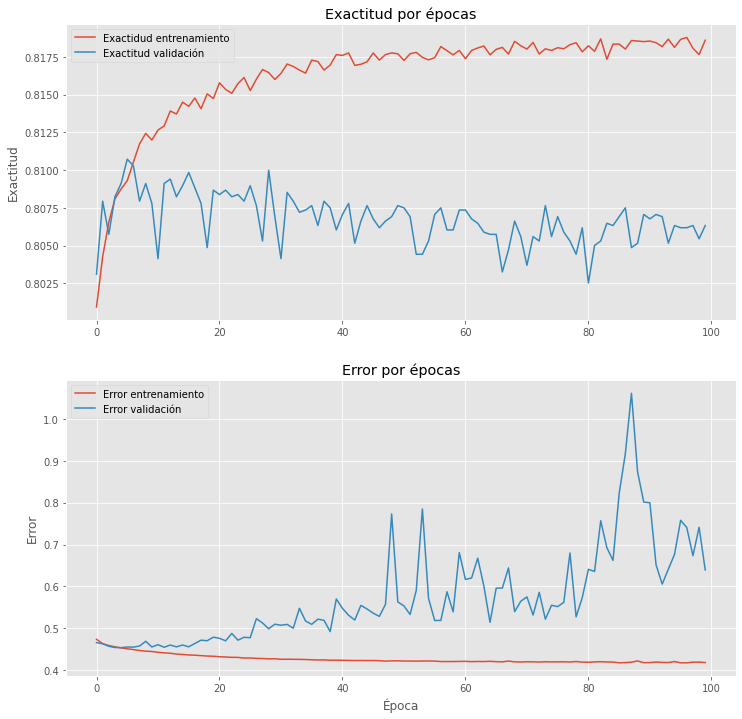

In [44]:
# Hacemos la figura
fig, axs = plt.subplots(2, figsize = (12, 12))

# Gráfica accuracy
axs[0].plot(history.history["accuracy"], label = "Exactidud entrenamiento")
axs[0].plot(history.history["val_accuracy"], label = "Exactitud validación")
axs[0].set_ylabel("Exactitud")
axs[0].legend(loc = "best")
axs[0].set_title("Exactitud por épocas")

# Gráfica error
axs[1].plot(history.history["loss"], label = "Error entrenamiento")
axs[1].plot(history.history["val_loss"], label = "Error validación")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Época")
axs[1].legend(loc = "best")
axs[1].set_title("Error por épocas")

# Mostramos la figura
plt.show()

<br>

---

<br>

# 5.)

## Desempeño de los modelos

### Accuracy:

### Matriz de confusión:

### Curva ROC:

## Variables más importantes

## Posibles incorporaciones futuras al modelo que podrían mejorar el desempeño de este

- Se podría agregar la variable `condiciones_climaticas` al modelo. Donde la variable `condiciones_climaticas` es una variable categórica que indica si el día del vuelo estaba soleado, nublado, lluvioso, etc. Así podríamos ver si el clima influye en el retraso de los vuelos.
- También se podría agregar una variable `distancia` que indique la distancia entre el aeropuerto de origen y el aeropuerto de destino. Así podríamos ver de mejor manera si la distancia influye en el retraso de los vuelos.
- Otra cosa que se podría hacer es utilizar una red neuronal más robusta, a ver si se obtienen mejores resultados.
- Por último, se podría tomar también data de años anteriores, así se tendría más data para entrenar el modelo lo que probablemente mejoraría el desempeño de este.

<br>

---

<br>